# Generating dtopo files for CSZ fakequakes

This requires `cascadia30.mshout` containing the geometry of the triangulated fault surface, and a rupture scenario in the form of a `.rupt` file from the collection of fakequakes at  <https://zenodo.org/record/59943#.WgHuahNSxE4>.

It also assumes `dtopotools.py` handles triangular subfaults.  This has not yet been merged into `master` in GeoClaw.


In [1]:
%matplotlib inline

In [2]:
#from clawpack.geoclaw import dtopotools
import dtopotools
import numpy as np
from copy import copy
import matplotlib.pyplot as pl
import os

### Set up CSZ geometry

In [7]:
fault_geometry_file = './cascadia30.mshout'
print('Reading fault geometry from %s' % fault_geometry_file)
print('\nHeader:\n')
print(open(fault_geometry_file).readline())

Reading fault geometry from ./cascadia30.mshout

Header:

#   fault No. , centroid(lon,lat,z[km]) , node1(lon,lat,z[km]) , node2(lon,lat,z[km]) , node3(lon,lat,z[km]) , mean vertex length(km) , area(km^2) , strike(deg) , dip(deg)



In [8]:
# read in .mshout (CSZ geoemetry)

cascadia = np.loadtxt(fault_geometry_file,skiprows=1)
cascadia[:,[3,6,9,12]] = 1e3*abs(cascadia[:,[3,6,9,12]])

For example, the first triangular fault in the given geometry of CSZ has the nodes

In [9]:
print(cascadia[0,4:7])
print(cascadia[0,7:10])
print(cascadia[0,10:13])

[ -125.36073     46.302805  8795.382   ]
[  -125.311684     46.526803  10094.313   ]
[  -125.038743     46.426986  13526.373   ]


We now read in rupture scenario, using data from <https://zenodo.org/record/59943#.WgHuahNSxE4>

We assume that the downloaded file is unzipped and placed in the directory specified by `data_dir` below.

In [10]:
# Set data directory:
data_dir = '/Users/rjl/FakeQuakes/data/'

# Set desired scenario number:
rupture_scenario_no = 1266

rupt_fname_suffix = '{:0>6d}'.format(rupture_scenario_no)
rupt_fname = data_dir + 'cascadia.' + rupt_fname_suffix \
                    + '/_cascadia.' + rupt_fname_suffix + '.rupt'
print("Reading earthquake data from %s" % rupt_fname)
rupture_parameters = np.loadtxt(rupt_fname,skiprows=1)

Reading earthquake data from /Users/rjl/FakeQuakes/data/cascadia.001266/_cascadia.001266.rupt


### Compute seafloor deformations with GeoClaw 

We then set the GeoClaw dtopotools fault as follows:

In [11]:
fault0 = dtopotools.Fault()
fault0.subfaults = []
fault0.rupture_type = 'kinematic'
rake = 90.
slip = 1.

J = int(np.floor(cascadia.shape[0]))

for j in range(J):
    subfault0 = dtopotools.SubFault()
    node1 = cascadia[j,4:7].tolist()
    node2 = cascadia[j,7:10].tolist()
    node3 = cascadia[j,10:13].tolist()
    node_list = [node1,node2,node3]
    
    ss_slip = rupture_parameters[j,8]
    ds_slip = rupture_parameters[j,9]
    
    rake = np.rad2deg(np.arctan2(ds_slip, ss_slip))
    
    subfault0.set_corners(node_list,rake=rake,projection_zone='10T')
    subfault0.rupture_time = rupture_parameters[j,12]
    subfault0.rise_time = rupture_parameters[j,7]
    

    slip = np.sqrt(ds_slip ** 2 + ss_slip ** 2)
    subfault0.slip = slip
    fault0.subfaults.append(subfault0)

Then run the ``create_dtopography`` routine to generate dynamic seafloor deformations at given times

In [12]:
x,y = fault0.create_dtopo_xy(dx = 4/60.)
print('Will create dtopo on arrays of shape %i by %i' % (len(x),len(y)))
tfinal = max([subfault1.rupture_time + subfault1.rise_time for subfault1 in fault0.subfaults])
times0 = np.linspace(0.,tfinal,100)
dtopo0 = fault0.create_dtopography(x,y,times=times0,verbose=True);

Will create dtopo on arrays of shape 106 by 181
Making Okada dz for each of 963 subfaults
0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..143..144..145..146..147..148..149..150..151..152..153..154..155..156..157..158..159..160..161..162..163..164..165..166..167..168..169..170..171..172..173..174..175..176..177..178..179..180..181..182..183..184..185..186..187..188..189..190..191..192..193..194..195..196..197..198..199..200..201..202..203..

In [13]:
x.shape,y.shape, dtopo0.dZ.shape

((106,), (181,), (100, 181, 106))

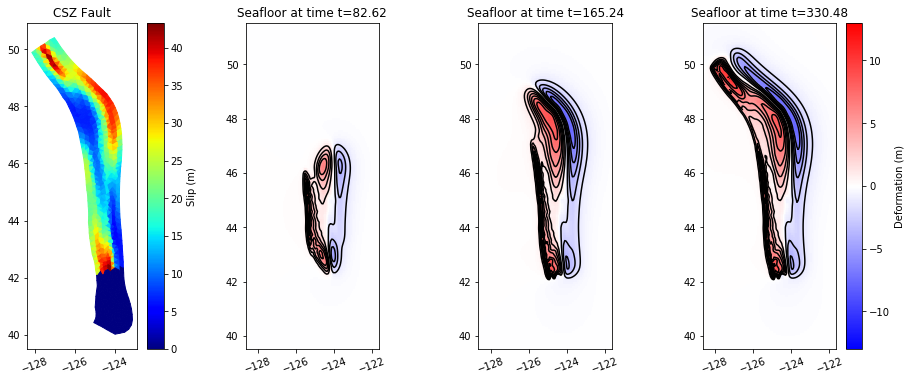

In [14]:
fig,(ax0,ax1,ax2, ax3) = pl.subplots(ncols=4,nrows=1,figsize=(16,6))
fault0.plot_subfaults(axes=ax0,slip_color=True,plot_box=False);
ax0.set_title('CSZ Fault');

X = dtopo0.X; Y = dtopo0.Y; dZ_at_t = dtopo0.dZ_at_t
dz_max = dtopo0.dZ.max()

t0 = 0.25*tfinal    # time to plot deformation
dtopotools.plot_dZ_colors(X,Y,dZ_at_t(t0),axes=ax1, 
                          cmax_dZ = dz_max, add_colorbar=False);
ax1.set_title('Seafloor at time t=' + str(t0));

t0 = 0.5*tfinal    # time to plot deformation
dtopotools.plot_dZ_colors(X,Y,dZ_at_t(t0),axes=ax2,
                          cmax_dZ = dz_max, add_colorbar=False);

ax2.set_title('Seafloor at time t=' + str(t0));

t0 = tfinal    # time to plot deformation
dtopotools.plot_dZ_colors(X,Y,dZ_at_t(t0),axes=ax3,
                          cmax_dZ = dz_max, add_colorbar=True);
ax3.set_title('Seafloor at time t=' + str(t0));

#fig.savefig('CSZ_triangular.png');

### Plot the rupture time and rise time of each subfault

This shows where the rupture originates and how it propagates outward.

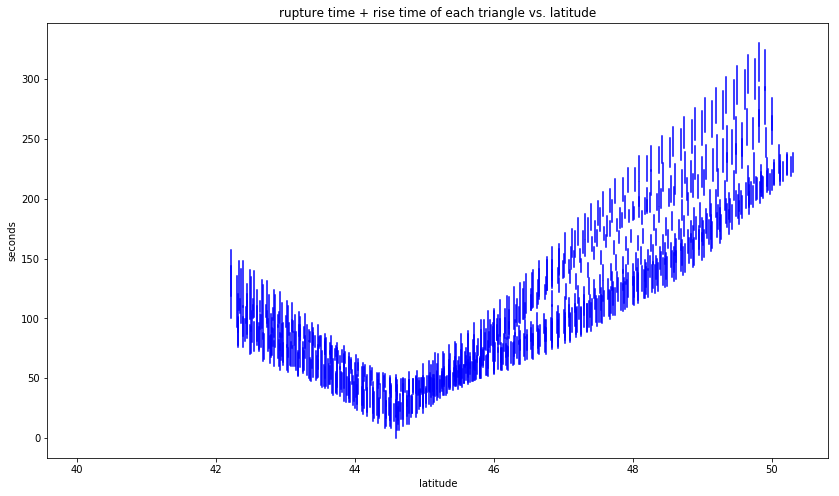

In [15]:
pl.figure(figsize=(14,8))
pl.axes()
latitudes = [s.latitude for s in fault0.subfaults]
rise_times = [s.rise_time for s in fault0.subfaults]
rupture_times = [s.rupture_time for s in fault0.subfaults]
for j,lat in enumerate(latitudes):
    pl.plot([lat,lat],[rupture_times[j],rupture_times[j]+rise_times[j]],'b')
pl.xlabel('latitude')
pl.ylabel('seconds')
pl.title('rupture time + rise time of each triangle vs. latitude')

### Plot the deformation as a function of time at a few locations

Same longitude, increasing latitude...

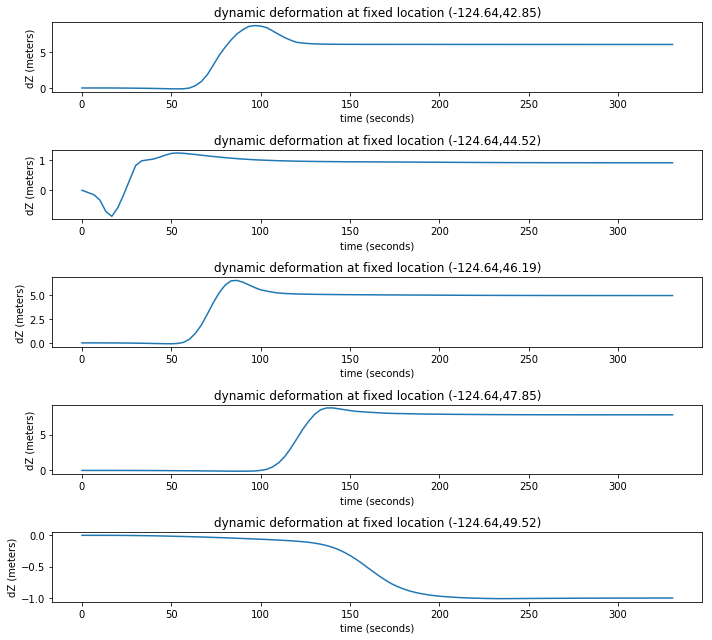

In [16]:
pl.figure(figsize=(10,9))
for kk in range(5):
    pl.subplot(5,1,kk+1)
    j = 60
    k = 50 + 25*kk
    pl.title('dynamic deformation at fixed location (' + '{:4.2f}'.format(x[j]) \
                                                 + ',' + '{:4.2f}'.format(y[k]) + ')' )
    pl.plot(dtopo0.times,dtopo0.dZ[:,k,j]);
    pl.ylabel('dZ (meters)');
    pl.xlabel('time (seconds)');
pl.tight_layout()

### Create a dtopo file for GeoClaw

And test by reading back in and plotting dtopo at final time...

In [17]:
fname = 'cascadia' + rupt_fname_suffix + 'a.dtt3'
dtopo0.write(fname, dtopo_type=3)

In [18]:
dtopo1 = dtopotools.DTopography()
dtopo1.read(fname,3)

In [19]:
dtopo1.dZ.shape

(100, 181, 106)

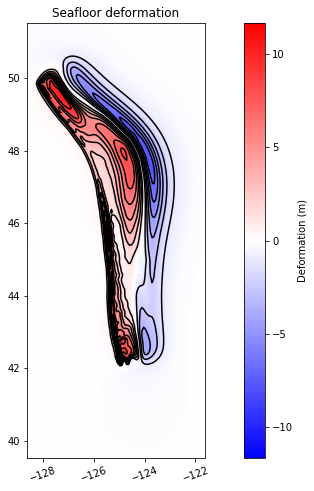

In [20]:
pl.figure(figsize=(14,8))
ax = pl.axes()
dtopo1.plot_dZ_colors(tfinal, ax)

### Animate the rupture:

In [21]:
from clawpack.visclaw.JSAnimation import IPython_display
import clawpack.visclaw.JSAnimation.JSAnimation_frametools as J

dz_max = abs(dtopo0.dZ).max()

# Incorporate this function in dtopotools to replace animate_dz_colors?
def plot_subfaults_dZ(t, fig):
    fig.clf()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fault0.plot_subfaults(axes=ax1, slip_color=True, plot_box=False,
                          slip_time=t)
    dtopo0.plot_dZ_colors(axes=ax2, t=t, cmax_dZ=dz_max)
    return fig

plotdir = '_plots'
J.make_plotdir(plotdir, clobber=True)
fig = pl.figure(figsize=(12,5))

for k,t in enumerate(dtopo0.times[::10]):
    plot_subfaults_dZ(t,fig)
    J.save_frame(k, verbose=False)
    
pl.close(fig)

Figure files for each frame will be stored in  _plots



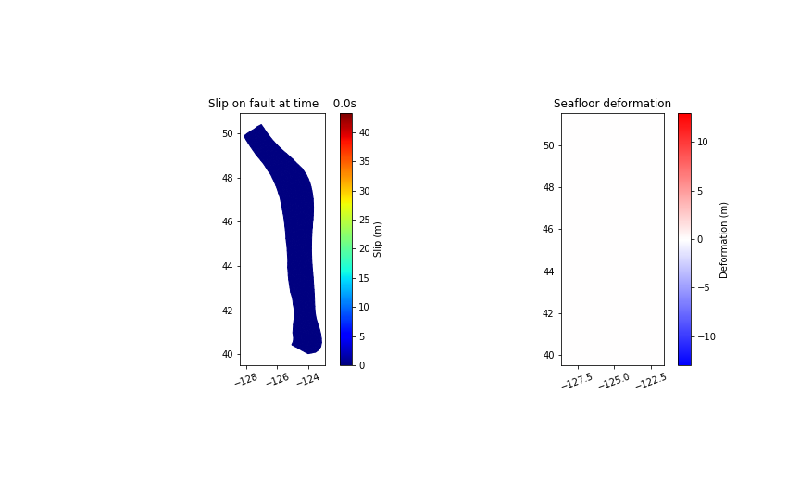
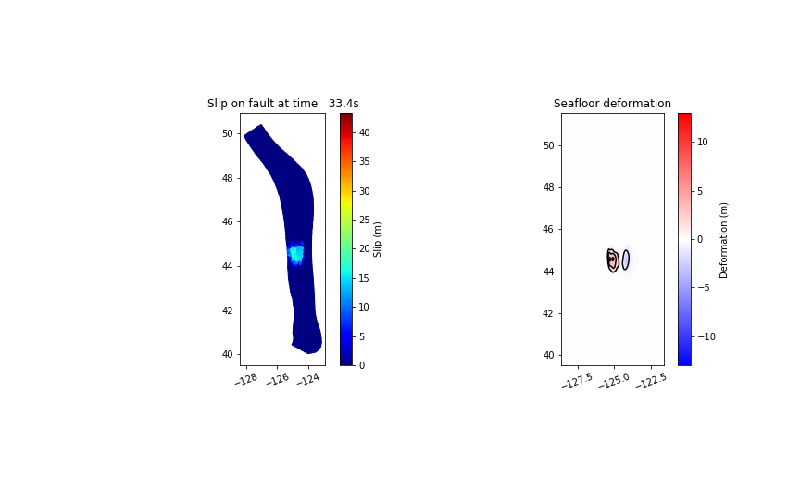
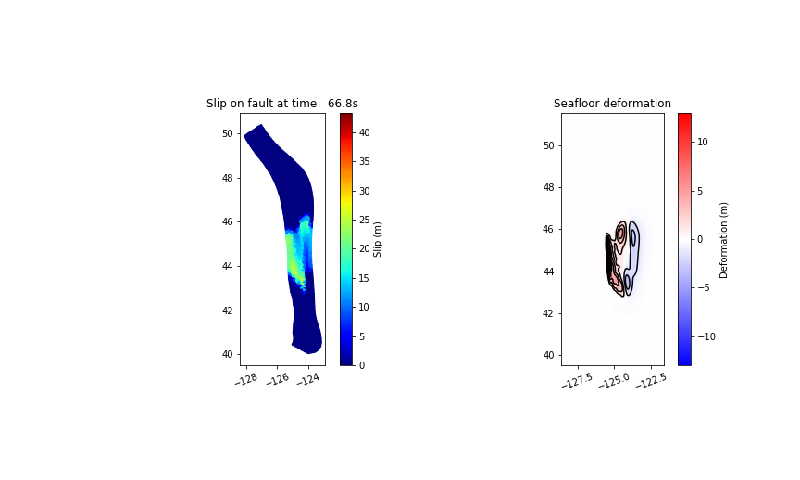
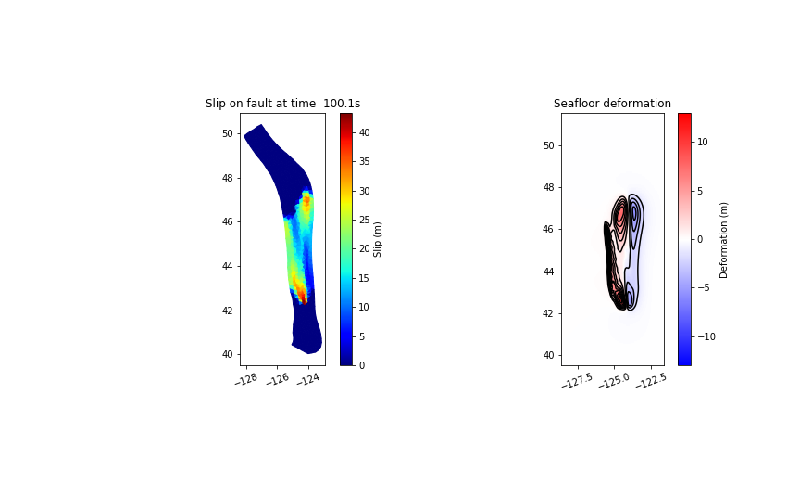
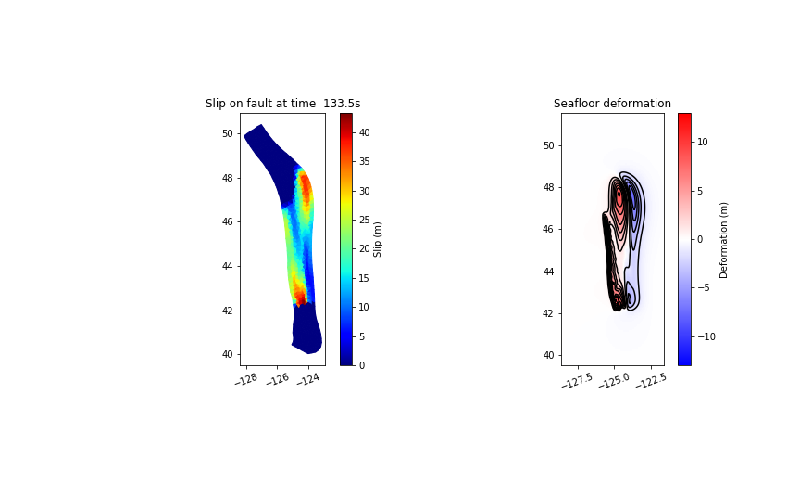
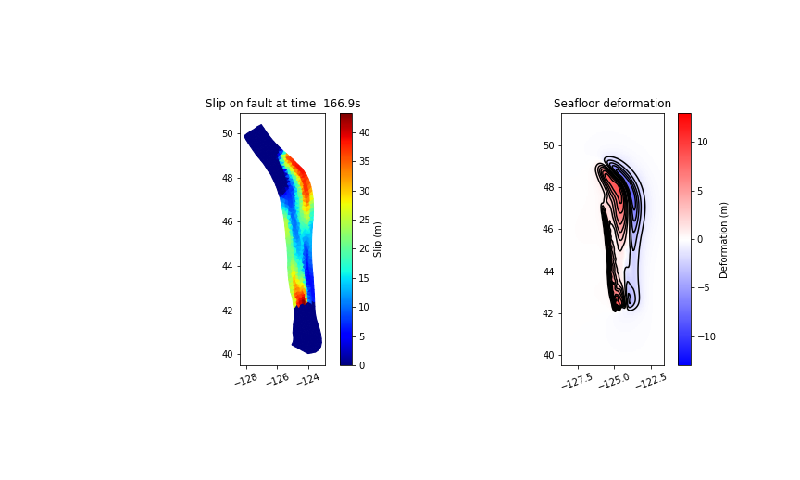
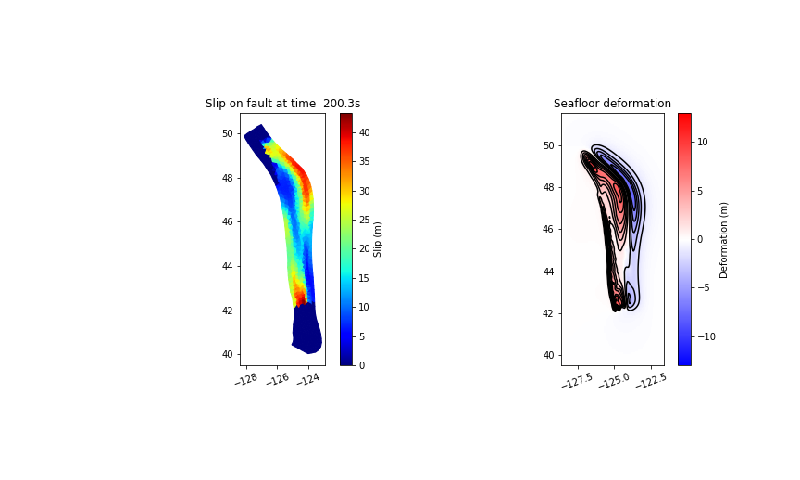
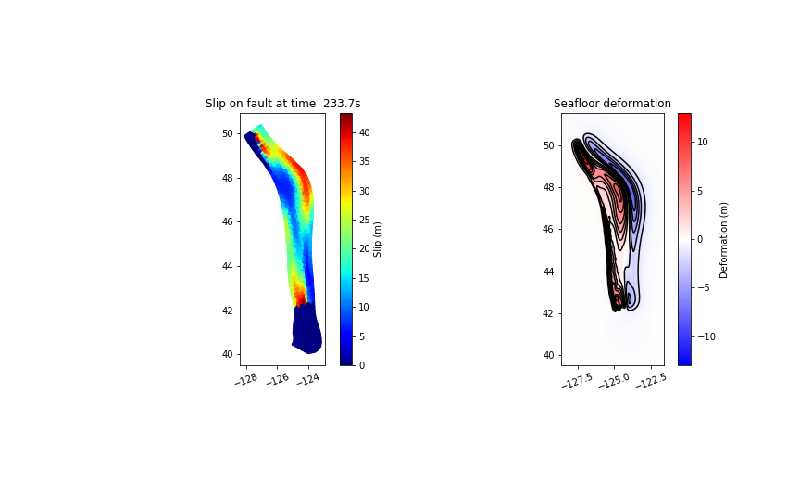
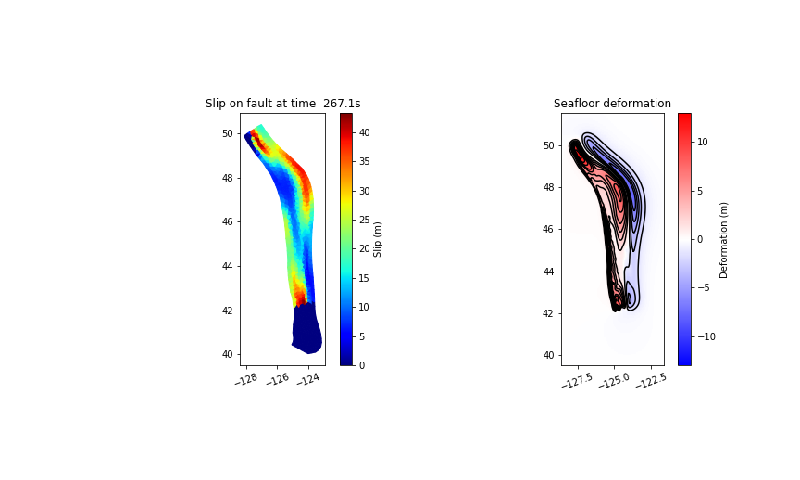
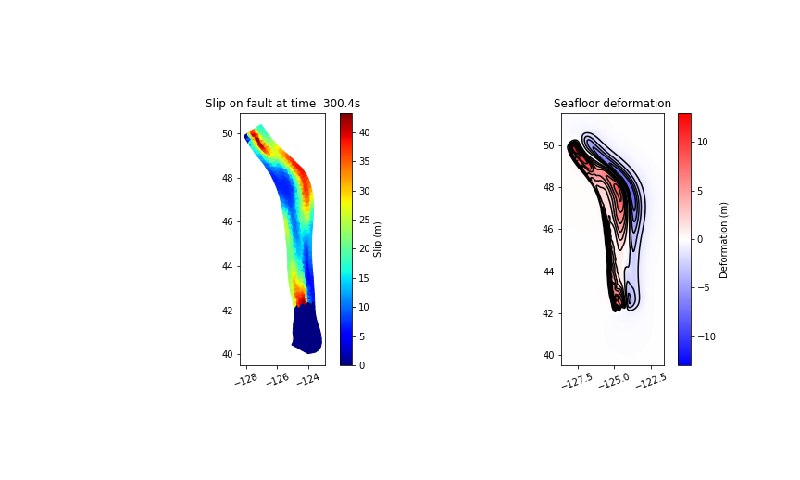

In [22]:
anim = J.make_anim(plotdir)
anim